In [3]:
# mount google drive --> if you run on colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change directory to your project
import os
project_dir = '/content/drive/My Drive/BMG_Case_Study'
os.chdir(project_dir)

In [5]:
# install dependencies
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.9 MB/s eta 0:00:00


In [6]:
# import libraries
import numpy as np
import pandas as pd
import sqlite3
from openpyxl import load_workbook
%run model.py

## Data

> Data is prepared and cleaned mainly with duplicate removals and date time conversion

In [7]:
# read the df
df = pd.read_csv("spotify_charts_germany_only.csv")

In [8]:
# drop duplicated
df = df.drop_duplicates()

In [9]:
# check for length and columns
print("The shape of data is {}".format(df.shape))

# Check for null values
print(df.isnull().sum())

# See the data (first few rows)
#print(df.head())


# unique value columns
print("The unique columns in each data")
for col in df.columns:
  print(f'{col}: {df[col].nunique()}')


The shape of data is (27600, 14)
chart_country_code       0
chart_market             0
week_start_date          0
chart_rank               0
spotify_artist_id        0
artist_name              1
isrc                  2495
spotify_track_id         0
track                    1
label                    0
major_label           2495
genre                 2513
release_date           281
streams                  0
dtype: int64
The unique columns in each data
chart_country_code: 1
chart_market: 1
week_start_date: 138
chart_rank: 200
spotify_artist_id: 2008
artist_name: 2010
isrc: 3151
spotify_track_id: 3907
track: 3398
label: 779
major_label: 6
genre: 13
release_date: 791
streams: 27184


| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| chart_market        | Country of the Top-200 charts                                               |
| week_start_date     | Calendar date of first day of the week of the charts                        |
| chart_rank      | Which position did the track have in this week                              |
| spotify_artist_id   | The Spotify ID for the main artists of the track                            |
| artist_name         | The artist names for the track                                              |
| isrc                | International Standard Recording Code, an industry-wide identifier for a track |
| spotify_track_id    | The Spotify ID for a track                                                  |
| label               | The name of the label that owns the track                                   |
| major_label         | The major or large label that owns the rights to this track                 |
| genre               | Information about which genre the track might belong to                     |
| release_date        | The date the track was released                                             |
| streams             | Number of streams the track had in this week on Spotify in Germany          |


In [10]:
# drop na values in release_date
df = df.dropna(subset=['release_date'])

In [11]:
# Function to fix 2-digit year issues by adding '20' prefix to yy part
def fix_century_full(date_str):
    try:
        parts = date_str.split('.')
        yy = int(parts[2])
        # If year is >= 30, assume 1900s (e.g., 97 → 1997), else 2000s
        parts[2] = ('19' if yy >= 30 else '20') + parts[2].zfill(2)
        return '.'.join(parts)
    except Exception:
        return date_str

# Apply fix to both columns
df['week_start_date'] = df['week_start_date'].astype(str).apply(fix_century_full)
df['release_date'] = df['release_date'].astype(str).apply(fix_century_full)

# Convert to datetime using corrected 'dd.mm.yyyy' format
df['week_start_date'] = pd.to_datetime(df['week_start_date'], format='%d.%m.%Y', errors='coerce')
df['release_date']    = pd.to_datetime(df['release_date'], format='%d.%m.%Y', errors='coerce')

# Filter out rows where release_date is greater than week_start_date
df = df[df['release_date'] <= df['week_start_date']]

# Calculate day difference and format back to 'dd.mm.yyyy' if needed
df['day_since_launch'] = (df['week_start_date'] - df['release_date']).dt.days

In [12]:
# Connect and write DataFrame to SQLite
conn = sqlite3.connect('BMG.db')
df.to_sql('bmg_db', conn, if_exists='replace', index=False)
conn.close()

## Data Table


> SQL pipelines were used to create intermediate tables that aggregate and transform the raw data, enabling efficient and structured input for visualization and modeling. These tables support key metrics such as stream counts, peak positions, and genre or label-based trends.

In [13]:
def save_query_to_table(query, table_name, save_to_excel=True, file_name='Visualisation_Sheets/bmg_db.xlsx'):
    """
    Saves the result of a SQL query to a table in the BMG.db database and optionally to an Excel file,
    overwriting the Excel sheet if it already exists.

    Args:
        query: The SQL query to execute.
        table_name: The name of the table to create or append to.
        save_to_excel: Whether to save the results to Excel (default: True).
        file_name: The path to the Excel file (default: 'Visualisation_Sheets/bmg_db.xlsx').
    """
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect('BMG.db')

        # Execute the query and store results in a DataFrame
        df_result = pd.read_sql_query(query, conn)

        # Save to SQLite database
        df_result.to_sql(table_name, conn, if_exists='append', index=False)

        if save_to_excel:
            # Ensure the directory exists
            os.makedirs(os.path.dirname(file_name), exist_ok=True)

            if os.path.exists(file_name):
                # Load existing workbook and remove the sheet if it exists
                book = load_workbook(file_name)

                # Delete sheet if it already exists
                if table_name in book.sheetnames:
                    std = book[table_name]
                    book.remove(std)
                    book.save(file_name)

                # Now write new sheet (will overwrite cleanly)
                with pd.ExcelWriter(file_name, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
                    df_result.to_excel(writer, sheet_name=table_name, index=False)

            else:
                # Create new workbook
                with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
                    df_result.to_excel(writer, sheet_name=table_name, index=False)

        conn.close()

    except Exception as e:
        print(f"An error occurred: {e}")

In [14]:
text = """
SELECT
  *
FROM bmg_db
"""
save_query_to_table(text, "bmg_db", save_to_excel = True, file_name = 'Visualisation_Sheets/bmg_db.xlsx')

In [15]:
## time and stream to reach in top-10 -> exclude songs which did not reach top-10
text = """
WITH top_10_artists AS (
  SELECT
    *,
    MIN(chart_rank) OVER (PARTITION BY spotify_track_id) AS min_rank,
    MIN(day_since_launch) OVER (PARTITION BY spotify_track_id) AS min_day_since_launch,
    CASE
      WHEN chart_rank = MIN(chart_rank) OVER (PARTITION BY spotify_track_id) THEN 1
      ELSE 0
    END AS flag
  FROM bmg_db
)

SELECT
  DISTINCT
  artist_name,
  spotify_track_id,
  chart_rank,
  genre,
  major_label,
  streams,
  week_start_date,
  release_date,
  day_since_launch
FROM top_10_artists
WHERE
  min_rank <= 10
  AND flag = 1
  AND day_since_launch = min_day_since_launch
  AND chart_rank = min_rank
"""
# save it
save_query_to_table(text, "top_10", save_to_excel = True, file_name = 'Visualisation_Sheets/bmg_db.xlsx')

In [16]:
## how much time did it stay in top 200 -> behaviour change with time
text = """
WITH top_200_stats AS (
  SELECT
    spotify_track_id,
    MAX(streams) AS max_streams,
    MIN(day_since_launch) AS min_day,
    MAX(day_since_launch) AS max_day,
    COUNT(DISTINCT week_start_date) AS weeks_on_chart
  FROM bmg_db
  WHERE chart_rank <= 200
  GROUP BY spotify_track_id
)
SELECT
  DISTINCT
  t.spotify_track_id,
  a.artist_name,
  a.genre,
  a.major_label,
  a.release_date,
  t.max_streams,
  (t.max_day - t.min_day) AS days_in_top_200,
  t.weeks_on_chart
FROM top_200_stats t
JOIN bmg_db a ON a.spotify_track_id = t.spotify_track_id
GROUP BY t.spotify_track_id;
"""
# save it
save_query_to_table(text, "days_in_top_200", save_to_excel = True, file_name = 'Visualisation_Sheets/bmg_db.xlsx')

In [17]:
## market shares of different genres, major labels, and track releases (e.g., 80s, 90s, 2020s, frontline releases)
text = """
SELECT
  strftime('%Y-%m', week_start_date) AS year_month,
  genre,
  major_label,
  CASE
    WHEN release_date IS NULL THEN 'Unknown'
    WHEN release_date < '1990-01-01' THEN '1980s or earlier'
    WHEN release_date >= '1990-01-01' AND release_date < '2000-01-01' THEN '1990s'
    WHEN release_date >= '2000-01-01' AND release_date < '2010-01-01' THEN '2000s'
    WHEN release_date >= '2010-01-01' AND release_date < '2020-01-01' THEN '2010s'
    WHEN release_date >= '2020-01-01' THEN '2020s & Frontline'
    ELSE 'Other'
  END AS release_era,
  SUM(streams) AS total_streams
FROM bmg_db
--WHERE chart_rank <= 200
GROUP BY year_month, genre, major_label, release_era
ORDER BY year_month;
"""
# save it
save_query_to_table(text, "market_share", save_to_excel = True, file_name = 'Visualisation_Sheets/bmg_db.xlsx')

In [18]:
text = """
SELECT
  strftime('%Y-%m', week_start_date) AS year_month,
  genre,
  major_label,
  SUM(streams) AS total_streams,
  COUNT(DISTINCT spotify_track_id) AS unique_tracks
FROM bmg_db
GROUP BY year_month, major_label, genre
ORDER BY year_month
"""
# save it
save_query_to_table(text, "trend_values", save_to_excel = True, file_name = 'Visualisation_Sheets/bmg_db.xlsx')

In [19]:

text = """
  SELECT
  major_label,
  strftime('%Y', week_start_date) AS year,
  strftime('%m', week_start_date) AS month,
  COUNT(DISTINCT spotify_track_id) AS unique_tracks,
  SUM(streams) AS total_streams
FROM bmg_db
GROUP BY major_label, year, month
ORDER BY year DESC , month ASC
"""

save_query_to_table(text, "stream_per_month", save_to_excel = True, file_name = 'Visualisation_Sheets/bmg_db.xlsx')

## Modelling



In [20]:
# read the data
conn = sqlite3.connect('BMG.db')

# Execute the query and store results in a DataFrame
df = pd.read_sql_query('Select * from bmg_db', conn)

# close the connection
conn.close()

### Feature Engineering : Peak Position

1. **Early Streaming Performance**  
Captures a track’s initial performance in its first few weeks after debut on the charts.

2. **Temporal Trend Features**  
Quantifies the direction, magnitude, and variability of streaming activity across early weeks.

3. **Genre Popularity Context**  
Incorporates genre-wide averages to provide contextual benchmarks for each track.

4. **Metadata and Timing Features**  
Includes information about release timing, debut seasonality, and whether the label is a major one.

5. **Structural Coverage Features**  
Reflects the number of weeks available and whether enough early data exists for modeling.

6. **Encoded Categorical Features**  
Transforms categorical variables like genre, label, and release era into numerical representations for modeling.

In [21]:
# sort and group by
df_rank = df.sort_values(['spotify_track_id', 'week_start_date'])
df_rank = df_rank.groupby('spotify_track_id').agg(
    artist_name=('artist_name', 'first'),
    genre=('genre', 'first'),
    major_label=('major_label', 'first'),
    release_date=('release_date', 'first'),
    debut_week=('week_start_date', 'min'),
    peak_position=('chart_rank', 'min')
).reset_index()

In [22]:
# Extract early performance stats
def early_features(group):
    out = {}
    weekly = group.sort_values('week_start_date')
    out['week1_streams'] = weekly['streams'].iloc[0] if len(weekly) > 0 else np.nan
    out['week2_streams'] = weekly['streams'].iloc[1] if len(weekly) > 1 else np.nan
    out['week3_streams'] = weekly['streams'].iloc[2] if len(weekly) > 2 else np.nan
    out['avg_streams_3weeks'] = weekly['streams'].iloc[:3].mean() if len(weekly) >= 3 else np.nan
    out['week2_growth'] = (out['week2_streams'] - out['week1_streams']) / out['week1_streams'] if out['week1_streams'] else np.nan
    out['week3_growth'] = (out['week3_streams'] - out['week2_streams']) / out['week2_streams'] if out['week2_streams'] else np.nan
    out['weeks_available'] = len(weekly)
    return pd.Series(out)

# group by and join
early_stats = df.groupby('spotify_track_id').apply(early_features).reset_index()
df_rank     = pd.merge(df_rank, early_stats, on='spotify_track_id', how='left')

In [23]:
# Add temporal and categorical metadata -> seasonal components in months

df_rank['release_date']    = pd.to_datetime(df_rank['release_date'])
df_rank['debut_week']      = pd.to_datetime(df_rank['debut_week'])

# get the features
df_rank['release_year']    = df_rank['release_date'].dt.year
df_rank['release_month']   = df_rank['release_date'].dt.month
df_rank['track_age_weeks'] = ((df_rank['debut_week'] - df_rank['release_date']).dt.days / 7).astype(int)
df_rank['debut_month']     = df_rank['debut_week'].dt.month
#df_rank['debut_year']      = df_rank['debut_week'].dt.year

# get the era
df_rank['release_era']     = pd.cut(
    df_rank['release_year'],
    bins=[0, 1989, 1999, 2009, 2019, 2100],
    labels=['1980s or earlier', '1990s', '2000s', '2010s', '2020s & Frontline']
)

# get the major labels
df_rank['is_major_label']  = df_rank['major_label'].isin(['UMG', 'Sony', 'Warner']).astype(int)

In [24]:
# Encode categorical variables
df_rank['genre']           = df_rank['genre'].astype('category')
df_rank['major_label']     = df_rank['major_label'].astype('category')
df_rank['release_era']     = df_rank['release_era'].astype('category')
df_rank['genre_cat']       = df_rank['genre'].cat.codes
df_rank['major_label_cat'] = df_rank['major_label'].cat.codes
df_rank['release_era_cat'] = df_rank['release_era'].cat.codes

In [25]:
# Engagement flags
df_rank['has_3_weeks'] = (df_rank['weeks_available'] >= 3).astype(int)

# Temporal trend features
df_rank['stream_delta_week2'] = df_rank['week2_streams'] - df_rank['week1_streams']
df_rank['stream_delta_week3'] = df_rank['week3_streams'] - df_rank['week2_streams']
df_rank['acceleration']       = df_rank['week3_growth'] - df_rank['week2_growth']
df_rank['stream_std_3weeks']  = df_rank[['week1_streams', 'week2_streams', 'week3_streams']].std(axis=1)

# Genre popularity context
genre_stats = df_rank.groupby('genre_cat')['avg_streams_3weeks'].mean().to_dict()
df_rank['genre_avg_streams'] = df_rank['genre_cat'].map(genre_stats)

In [26]:
# Engagement flags
df_rank['has_3_weeks'] = (df_rank['weeks_available'] >= 3).astype(int)

# Define feature set
feature_columns = [
    # get the streams
      'week1_streams'
    , 'week2_streams'
    , 'week3_streams'
    , 'avg_streams_3weeks'
    , 'week2_growth'
    , 'week3_growth'

    # momentum
    , 'stream_delta_week2'
    , 'stream_delta_week3'
    , 'acceleration'
    , 'stream_std_3weeks'
    , 'genre_avg_streams'
    , 'is_major_label'

    #temporal data
    #,'release_year'
    , 'release_month'
    , 'weeks_available'
    , 'has_3_weeks'
    , 'track_age_weeks'
    , 'debut_month'
    #, 'debut_year'
    , 'genre_cat'
    , 'major_label_cat'
    , 'release_era_cat'
]

In [27]:
# Fill missing values with median (alternative to dropping rows)
for col in feature_columns:
    median_val = df_rank[col].median()
    df_rank[col] = df_rank[col].fillna(median_val)

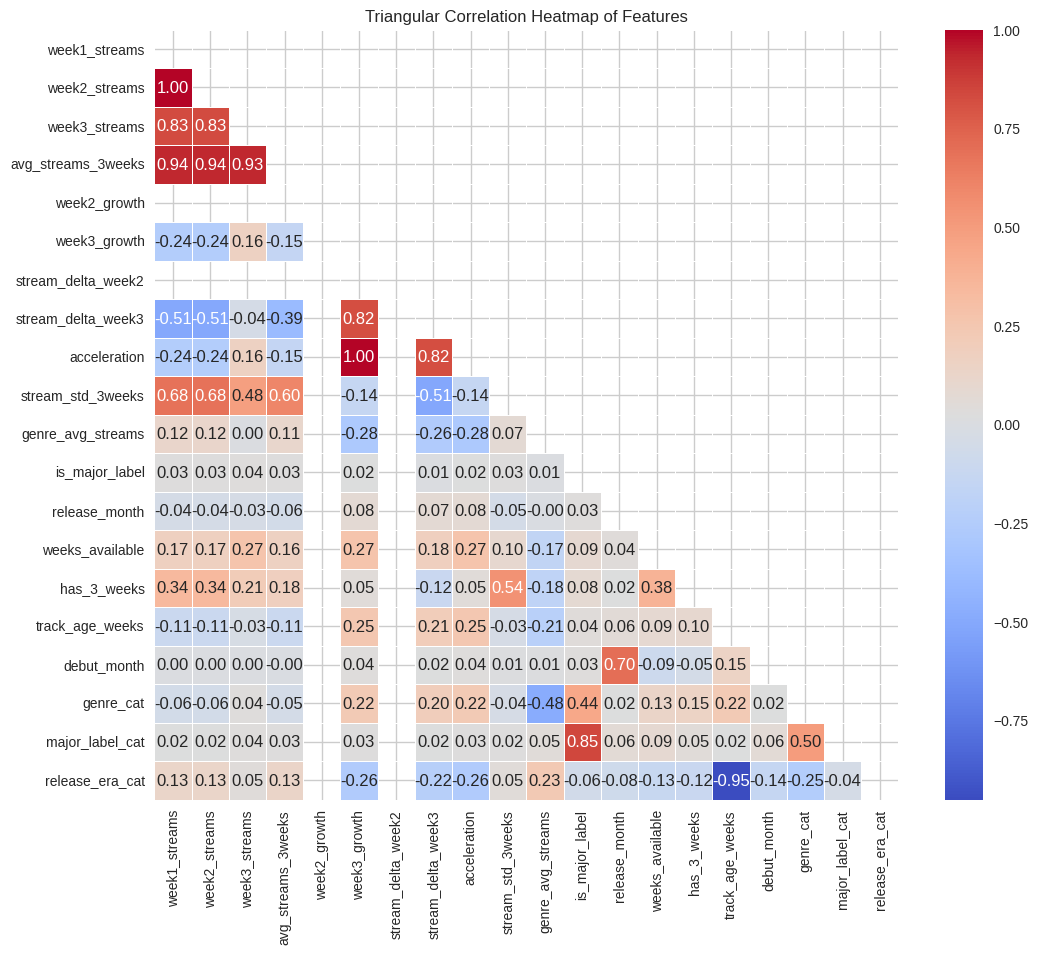

In [28]:
def drop_multicollinear_features(df, features, threshold=0.75):
    """
    Plots a triangular correlation heatmap and identifies features to drop
    due to multicollinearity based on a given threshold.

    Args:
        df (pd.DataFrame): The input DataFrame.
        features (list): A list of numerical feature column names to check.
        threshold (float): The absolute correlation threshold above which
                           features are considered multicollinear.

    Returns:
        list: A list of features to drop based on the threshold.
    """
    # Calculate the correlation matrix
    corr_matrix = df[features].corr()

    # Plot triangular correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Triangular Correlation Heatmap of Features')
    plt.show()

    # Identify multicollinear features to drop
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

    return to_drop

# Example usage with the defined feature_columns
features_to_check = feature_columns.copy() # Use a copy to avoid modifying the original list
features_to_drop = drop_multicollinear_features(df_rank.copy(), features_to_check, threshold=0.75)

In [29]:
# drop it
feature_columns = [col for col in feature_columns if col not in features_to_drop]

### Modelling : Peak Position prediction

In [30]:
# get the values
X    = df_rank[feature_columns].values
y    = df_rank['peak_position'].values
cols = df_rank[feature_columns].columns

In [31]:
# initiate the model
reg = regression(X,y,cols)

The len of train data is 3069
The len of test data is 768


In [32]:
# Linear Regression
reg.linear_regression()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.847
Model:                            OLS   Adj. R-squared (uncentered):              0.846
Method:                 Least Squares   F-statistic:                              1538.
Date:                Wed, 21 May 2025   Prob (F-statistic):                        0.00
Time:                        07:52:06   Log-Likelihood:                         -15660.
No. Observations:                3069   AIC:                                  3.134e+04
Df Residuals:                    3058   BIC:                                  3.141e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Performing modelling for Random forest

Best parameters = {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 25}

The metrics of regression are :
Mean Absolute Error: 13.43381021947737
Mean Absolute Percentage Error: 0.2977657020278457
Mean Squared Error: 370.0126532238491
Root Mean Squared Error: 19.2357129637518
R Squared: 0.8905236009254005

The feature importance are :
              variable  importance
0        week1_streams    0.722937
4    stream_std_3weeks    0.112255
8      weeks_available    0.093250
11         debut_month    0.022906
2         week3_growth    0.017220
10     track_age_weeks    0.013345
7        release_month    0.007957
12           genre_cat    0.005564
5    genre_avg_streams    0.002742
6       is_major_label    0.001210
9          has_3_weeks    0.000615
3   stream_delta_week2    0.000000
1         week2_growth    0.000000
The results of your model are:


,Model,MAE,MAPE,MSE,RMSE,R_Squared
0,Linear Regression,33.151572,1.569538,1654.319299,40.673324,0.510533
1,Random Forest,13.433810,0.297766,370.012653,19.235713,0.890524


None
The residual and error plots


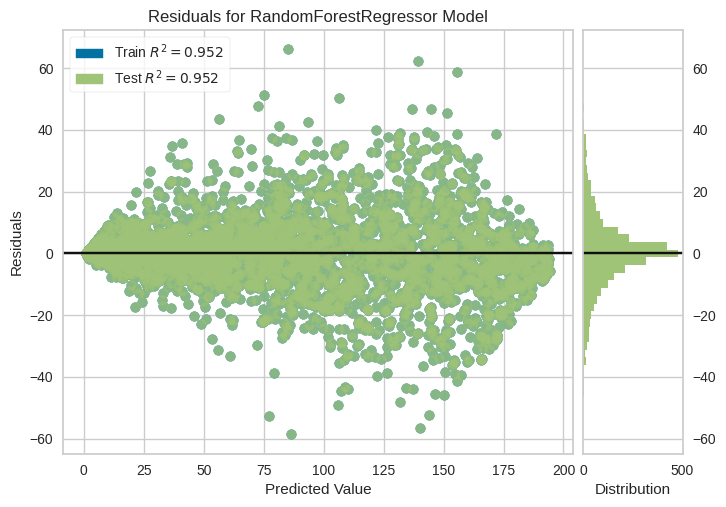

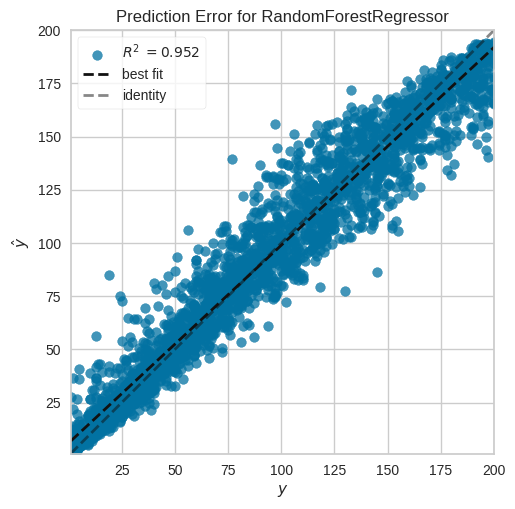

In [33]:
# Random Forest
model = reg.random_forest(feature_importance = True)
reg.result_plots(model,error_plots = True)

Performing modelling for XG Boost Regressor

Best parameters = {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'reg:squaredlogerror', 'subsample': 0.7}

The metrics of regression are :
Mean Absolute Error: 29.32501792907715
Mean Absolute Percentage Error: 0.5437368750572205
Mean Squared Error: 1536.69189453125
Root Mean Squared Error: 39.20066191445305
R Squared: 0.5453358292579651

The feature importance are :
              variable  importance
0        week1_streams    0.603417
4    stream_std_3weeks    0.157176
8      weeks_available    0.083512
10     track_age_weeks    0.069299
2         week3_growth    0.038173
12           genre_cat    0.010872
5    genre_avg_streams    0.010073
11         debut_month    0.010066
7        release_month    0.009739
6       is_major_label    0.007672
1         week2_growth    0.000000
3   stream_delta_week2    0.000000
9          has_3_weeks    0.000000
The results of your m

,Model,MAE,MAPE,MSE,RMSE,R_Squared
0,Linear Regression,33.151572,1.569538,1654.319299,40.673324,0.510533
1,Random Forest,13.433810,0.297766,370.012653,19.235713,0.890524
2,XG Boost,29.325018,0.543737,1536.691895,39.200662,0.545336


None
The residual and error plots


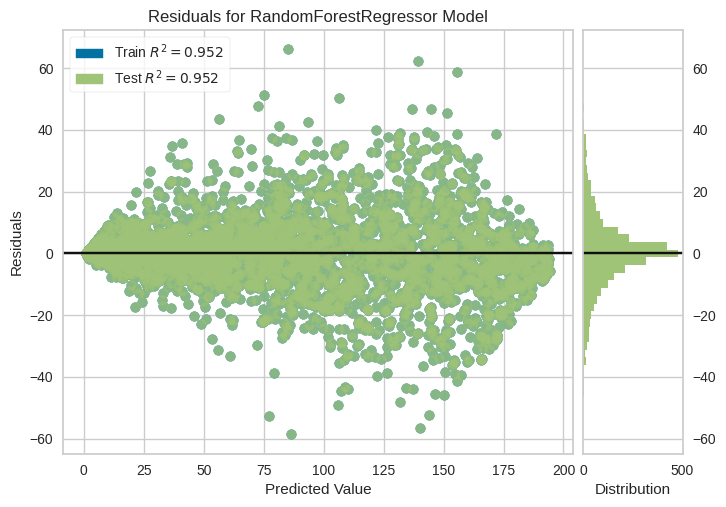

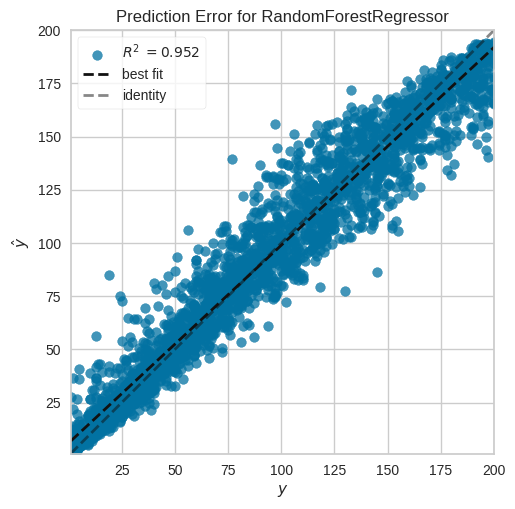

In [34]:
# XGBoost
reg.XG_Boost(feature_importance = True)
reg.result_plots(model,error_plots = True)

In [35]:
# model = reg.shallow_neural_net()
# reg.result_plots(model,error_plots = True)

In [36]:
# reg.SVR_regression()
# reg.result_plots(reg.SVR_regression(),error_plots = True)

### Feature Engineering : Streams prediction

In [37]:
# store it
df_stream = df

# Assuming `day_since_launch` is already calculated
df_stream['in_6_months'] = df_stream['day_since_launch'] <= 182

> Lognormal distribution: This plot shows a right-skewed distribution of total Spotify streams accumulated in the first 6 months by tracks on the chart.

Text(0.5, 0, 'Streams in First 6 Months')

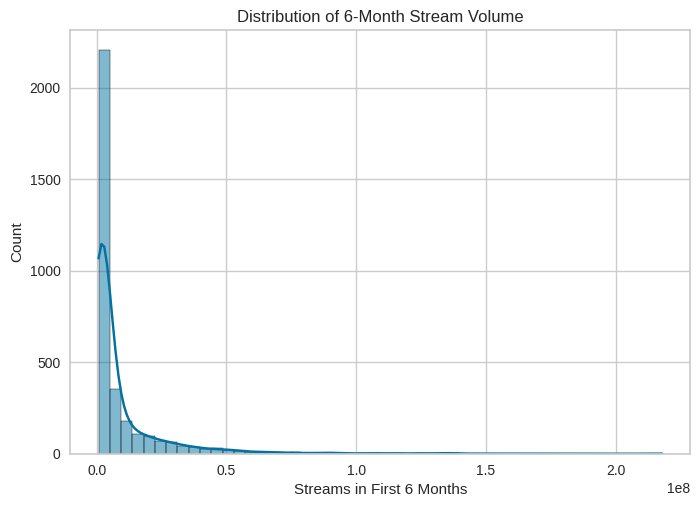

In [38]:
sns.histplot(df_stream[df_stream['in_6_months']].groupby('spotify_track_id')['streams'].sum().reset_index()['streams'], bins=50, kde=True)
plt.title('Distribution of 6-Month Stream Volume')
plt.xlabel('Streams in First 6 Months')

> We need to carefully curate the features of this model to predict stream for next 6 months.

In [39]:
df_stream = df_stream.sort_values(['spotify_track_id', 'week_start_date'])

# Create week index per track
df_stream['week_index'] = df_stream.groupby('spotify_track_id').cumcount() + 1

# Extract week1 to week3 streams and compute decay/growth
week_features = df_stream[df_stream['week_index'] <= 3].pivot(
    index='spotify_track_id',
    columns='week_index',
    values='streams'
)
week_features.columns = [f'week{i}_streams' for i in range(1, 4)]

# Add decay and growth indicators
week_features['stream_decay_ratio'] = week_features['week3_streams'] / week_features['week1_streams']
week_features['stream_growth_abs'] = week_features['week3_streams'] - week_features['week1_streams']

# Aggregate temporal stats over 6 months
agg_features = df_stream.groupby('spotify_track_id').agg(
    total_weeks_in_6m=('week_start_date', 'nunique'),
    total_streams_6m=('streams', 'sum'),
    min_chart_position=('chart_rank', 'min'),
    #avg_chart_position=('chart_rank', 'mean'),
    volatility_streams=('streams', 'std'),
    #chart_position_std=('chart_rank', 'std'),
    weekly_stream_growth=('streams', lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] if len(x) > 1 and x.iloc[0] > 0 else 0),
).reset_index()

# Merge features into a unified dataframe
feature_df = pd.merge(agg_features, week_features.reset_index(), on='spotify_track_id', how='left')

# drop features
agg_features = agg_features.drop(['spotify_track_id'], axis=1)

In [40]:
# fill na values with median
for col in agg_features.columns.tolist():
    col_median = agg_features[col].median()
    agg_features[col] = agg_features[col].fillna(col_median)

In [41]:
# remove outliers with IQR
Q1 = agg_features['total_streams_6m'].quantile(0.15)
Q3 = agg_features['total_streams_6m'].quantile(0.95)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

agg_features = agg_features[(agg_features['total_streams_6m'] >= lower_bound) & (agg_features['total_streams_6m'] <= upper_bound)]

In [42]:
# get the 6 month streams
# agg_features['total_streams_6m'] = np.log1p(agg_features['total_streams_6m'])

In [43]:
X = agg_features.drop(['total_streams_6m'], axis=1).values
y = agg_features['total_streams_6m'].values
cols = agg_features.drop(['total_streams_6m'], axis=1).columns

### Modelling : Stream Prediction

In [44]:
# initiate
reg = regression(X,y,cols, split_ratio = 0.2)

The len of train data is 3042
The len of test data is 761


In [45]:
reg.tweedie_regression() ##- > didn't work out

Best parameters = {'alpha': 0.01, 'power': 1.1}

The metrics of regression are :
Mean Absolute Error: 11003310.482858896
Mean Absolute Percentage Error: 4.7779465033355235
Mean Squared Error: 242287206511277.75
Root Mean Squared Error: 15565577.615728809
R Squared: -0.019661415787369796


TweedieRegressor(alpha=0.01, power=1.1)

In [46]:
reg.linear_regression()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.898
Model:                            OLS   Adj. R-squared (uncentered):              0.898
Method:                 Least Squares   F-statistic:                              6707.
Date:                Wed, 21 May 2025   Prob (F-statistic):                        0.00
Time:                        07:59:42   Log-Likelihood:                         -52363.
No. Observations:                3042   AIC:                                  1.047e+05
Df Residuals:                    3038   BIC:                                  1.048e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Performing modelling for Random forest

Best parameters = {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 25}

The metrics of regression are :
Mean Absolute Error: 1244047.280269218
Mean Absolute Percentage Error: 0.10930859443674806
Mean Squared Error: 11888855492942.87
Root Mean Squared Error: 3448021.968164192
R Squared: 0.9499659623032498

The feature importance are :
               variable  importance
0     total_weeks_in_6m    0.816075
1    min_chart_position    0.100705
2    volatility_streams    0.065706
3  weekly_stream_growth    0.017514
The results of your model are:


,Model,MAE,MAPE,MSE,RMSE,R_Squared
0,Tweedie Regression,1.100331e+07,4.777947,2.422872e+14,1.556558e+07,-0.019661
1,Linear Regression,3.277914e+06,0.988396,2.598464e+13,5.097513e+06,0.890644
2,Random Forest,1.244047e+06,0.109309,1.188886e+13,3.448022e+06,0.949966


None
The residual and error plots


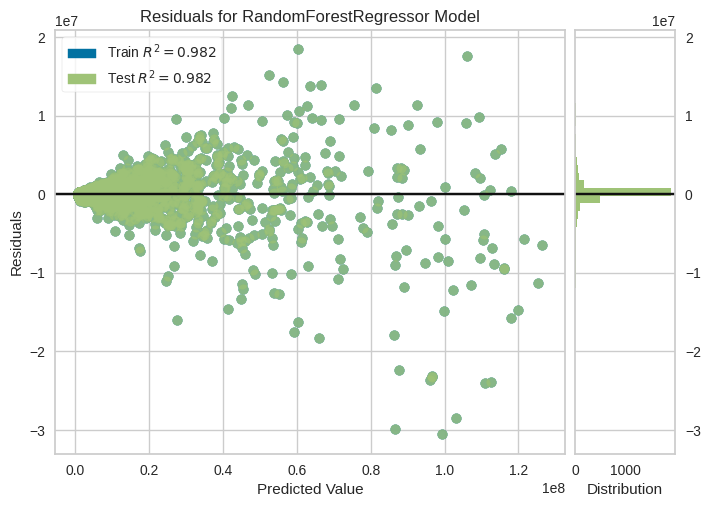

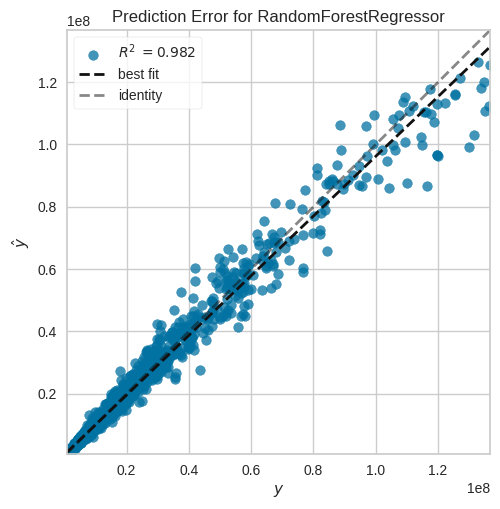

In [47]:
# random forest it
model = reg.random_forest(feature_importance = True)
reg.result_plots(model,error_plots = True)

Running Shallow Neural Network

The metrics of regression are :
Mean Absolute Error: 7227999.978151948
Mean Absolute Percentage Error: 1.1103004148926074
Mean Squared Error: 191454651140597.78
Root Mean Squared Error: 13836713.885189569
R Squared: 0.19426649284508535
The results of your model are:


,Model,MAE,MAPE,MSE,RMSE,R_Squared
0,Tweedie Regression,1.100331e+07,4.777947,2.422872e+14,1.556558e+07,-0.019661
1,Linear Regression,3.277914e+06,0.988396,2.598464e+13,5.097513e+06,0.890644
2,Random Forest,1.244047e+06,0.109309,1.188886e+13,3.448022e+06,0.949966
3,Shallow Neural Net,7.228000e+06,1.110300,1.914547e+14,1.383671e+07,0.194266


None
The residual and error plots


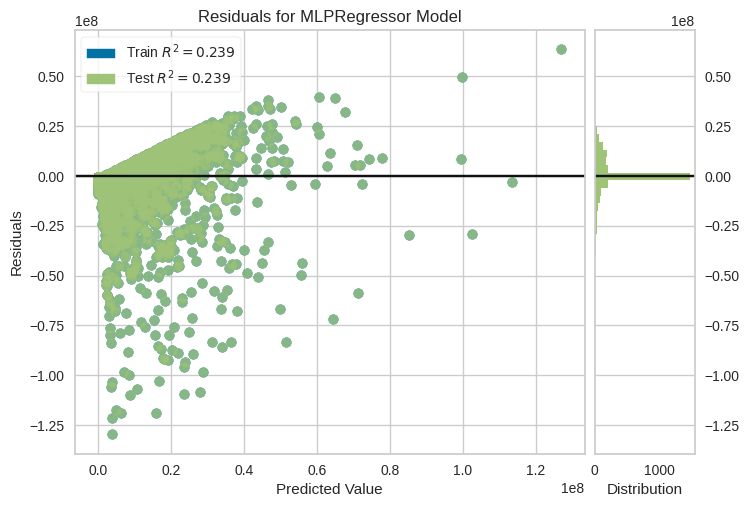

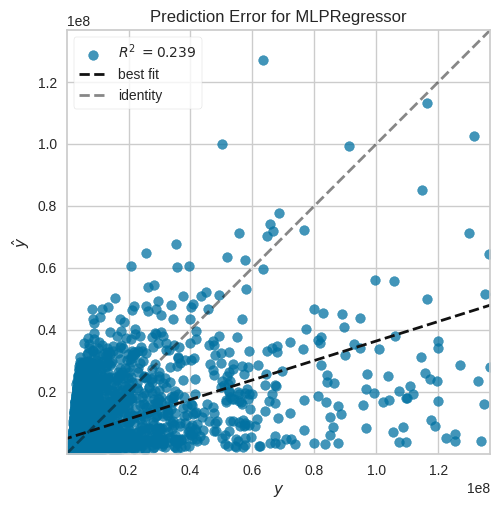

In [48]:
model = reg.shallow_neural_net()
reg.result_plots(model,error_plots = True)

In [49]:
# model = reg.XG_Boost(feature_importance = True)
# reg.result_plots(model, error_plots = True)

## Appendix